# 8.1 Stochastic Gradient Descent

In [1]:
import os.path
if  not os.path.isfile("OPT_helper.py"):
    !wget https://github.com/deeplearning-itba/optimizadores/raw/master/OPT_helper.py

In [3]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo
from sklearn.model_selection import train_test_split
import os.path
import keras
import numpy as np
from matplotlib import pyplot as plt
import OPT_helper
from OPT_helper import make_animation
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  after removing the cwd from sys.path.


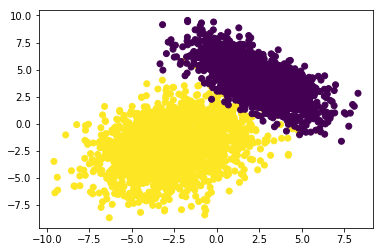

In [5]:
np.random.seed(432)

X = np.vstack([np.random.multivariate_normal([-2.5,-2], [[2,5],[5,1]], 2000),
             np.random.multivariate_normal([2.5,4], [[2,-3],[-3,2]], 2000)])
y = np.hstack([np.ones(2000),
             np.zeros(2000)])

#X=df[['Peso','Altura']].values
#y=df['Genero'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

# Optimizadores

Analizaremos distintas formas de minimizar la función de costo de una red neuronal o un regresor logístico o lineal.

Para mas información se recomienda la lectura de este [paper](https://arxiv.org/pdf/1609.04747.pdf)

## Gradient Descent

Debemos encontrar los valores de los parámetros que minimizan la función de costo.
Una alternativa es encontrar el mínimo de la función de costo iterativamente. Esto lo podemos hacer basándonos en los siguientes conceptos:

* Inicializamos los parámetros del modelo con un valor aleatorio: $\mathbf{\omega}(0)$
* El gradiente de la función de costo evaluado en un punto particular, nos dará la dirección de máxima variación de la función de costo. Es decir, si yo muevo al vector de parámetros en la dirección de máxima variación, el valor de la función de costo subirá a la tasa mas alta posible.
* Al contrario, si muevo al vector de parámetros en la dirección contraria, el valor de la función de costo bajará a la tasa mas alta posible: 
* Muevo los pesos muy poco en la dirección contraria a la del gradiente y vuelvo a calcular el gradiente en ese punto. $\mathbf{\omega}(k+1)=\mathbf{\omega}(k)-2\alpha\nabla(J(\mathbf{\omega}))$.
* Podemos terminar este proceso iterativo cuando $J$ sea mas chico que un valor deseado, o luego de un número de iteraciones fijo.

<img src="imagenes/grad.png" alt="Mountain View" style="width:600px;height:400px;">

A este proceso para hallar el mínimo de una función se lo conoce como Batch Gradient Descent.
Para cada peso en particular, lo podemos actualizar como:

$$\omega_1(k+1)=\omega_i(k)-\alpha\frac{1}{N}\sum_{j=0}^N( \omega \mathbf x^{(j)}-y^{(j)})x^{(j)}_i$$

## Stochastic Gradient Descent

Stochastic Gradient Descent es una simplificación de Batch Gradient Descent.
La misma consiste en reemplazar la función de costo total (la cual es el error cuadrático medio calculado para todo el set de muestras) por el error cuadrático instantáneo. Si hacemos esto, las ecuaciones de actualización de los pesos nos quedarán:

$$\omega_i(k+1)=\omega_i(k)-\alpha ( \omega \mathbf x^{(k)}-y^{(k)})x^{(k)}_i$$

El criterio de corte podrá ser por cantidad de iteraciones, o si el errór cuadrático instantáneo de todo un batch se mantiene por debajo de un valor predeterminado.


## Minibach gradient descent (muchas veces se incluye dentro de SGD)

Hemos visto cómo encontrar el mínimo de la superficie de error en forma iterativa de dos formas:

- Desde la ecuación del MSE (considerando todas las observaciones), moviendo los pesos paso a paso en dirección opuesta al gradiente de la superficie del error.(Batch-GD). Este método tiene mucho cálculo ya que para cada movimiento de los pesos hay que recalcular el gradiente en base al error de todas las muestras.
- Desde el error instantáneo (considerando una sola observación), moviendo los pesos en dirección opuesta al gradiente del error instantáneo, tomando una observación distinta a cada paso. (SGD). Este método tiene 

<img src="imagenes/stochastic-vs-batch-gradient-descent.png" alt="Mountain View" style="width:600px;height:400px;">


La solución provista por el primer método es mas estable ya que trabaja directamente con el gradiente de la superficie del MSE.  
El segundo método es mas ruidoso ya que solo tiene en cuenta el error instantáneo y opera sobre el supuesto de que para una gran cantidad de iteraciones, con un epsilon muy chico, se llegará al mismo mínimo que con el método anterior. En muchas iteraciones los pesos podrían moverse en dirección incluso opuesta al valor buscado. 

Una opción intermedia entre ambos métodos es utilizar el método llamado minibatch-GD. El mismo consiste en trabajar con el error cuadrático correspondiente a un número parcial de observaciones (algún número en el medio entre la totalidad de las observaciones y una sola observación). 

En definitiva todos los métodos se basan en la misma ecuación:

$$\omega_i(k+1)=\omega_i(k)-\alpha\frac{1}{N}\sum_{j=0}^N( \omega \mathbf x^{(j)}-y^{(j)})x^{(j)}_i$$

con:

GD: N=cantidad de observaciones  
SGD: N=1  
MBGD: 1<N<cantidad de observaciones  


In [6]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (2680, 2)
Training labels: (2680,)

Testing set data: (1320, 2)
Testing labels: (1320,)


# Red Neuronal de 1 capa

In [7]:
# Esta función recibe un modelo y devuelve los pesos que se quieren loggear
def get_weights(model):
    weights = list()
    
    for layer in model.layers[0:]:
        weights.append([layer.get_weights()[1][0], 
                        layer.get_weights()[0][0][0],
                        layer.get_weights()[0][1][0]])
    
    return weights

def set_weights(model, w0, w1, w2):
    weights = model.layers[0].get_weights()
    weights[0][0][0] = w1
    weights[0][1][0] = w2
    weights[1][0] = w0
    model.layers[0].set_weights(weights)

def reset_weights(model):
    weights = model.layers[-1].get_weights()
    weights[0][0] = weights[0][0] * 0
    model.layers[-1].set_weights(weights)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],
                activation='sigmoid', 
                kernel_initializer='zeros', 
                bias_initializer='zeros', 
                name='salida'))

optimizer = optimizers.SGD(lr=0.5, decay=0,nesterov=0)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

model.compile(loss = 'binary_crossentropy', optimizer=optimizer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
salida (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


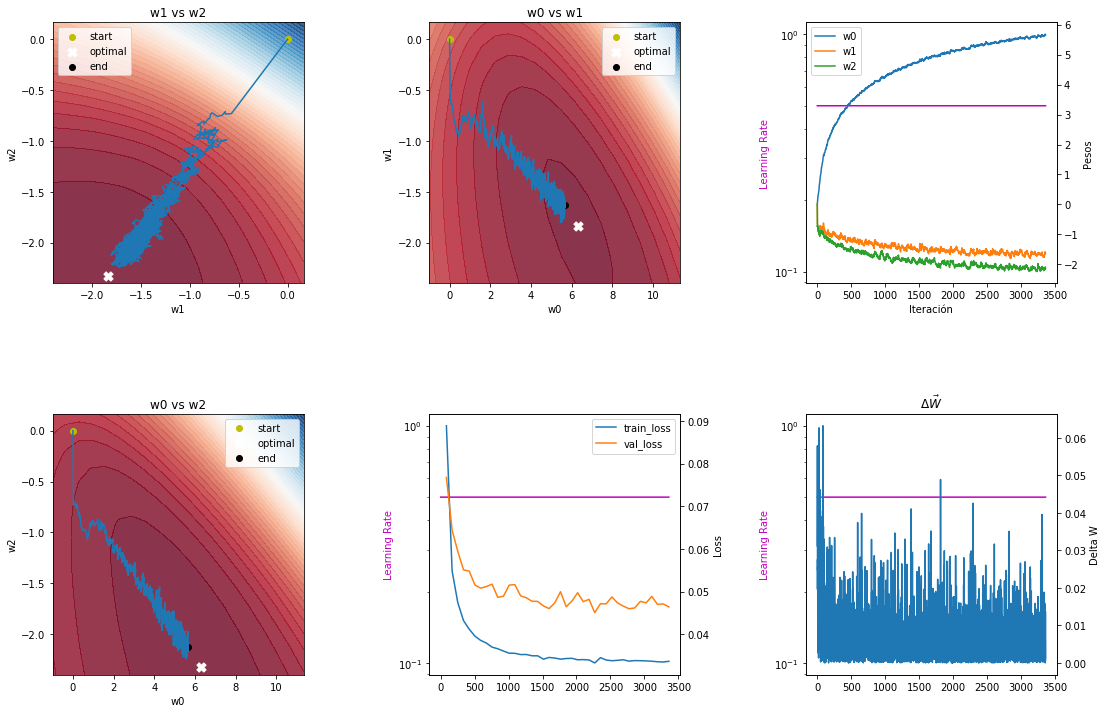

In [12]:
history = model.fit(x_train, 
          y_train ,
          epochs=40,
          batch_size=32, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights]
         )

In [13]:
make_animation(output_filename="videos/SGD.mp4",
               surface_filename="surface.pck",
               logWeights=logWeights,
               max_frames=500)

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [12]:
logWeights.history["weights_0"][-1]

[7.3284864, -1.5336183, -1.736]

La convergencia es muy ruidosa, podemos:
    
    - Subir el batch size
    - bajar el learning rate

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.5, decay=0,nesterov=0)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

history = model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights]
         )

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.25, decay=0,nesterov=0)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

model.compile(loss='binary_crossentropy', optimizer=optimizer)

history = model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=32, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights]
         )

## Early Stopping

En este caso ambos redujeron el ruido de convergencia, pero el aumento del batch size redujo notablemente el tiempo de convergencia.
En ambos casos se observa que en un momento del entrenamiento ya no hay mas mejoría, y no tiene sentido seguir entrenando el modelo, es por ello que se suele utilizar Early Stopping.

In [63]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.5, decay=0,nesterov=0)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=10, verbose=1, restore_best_weights=True)

logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

Restoring model weights from the end of the best epoch


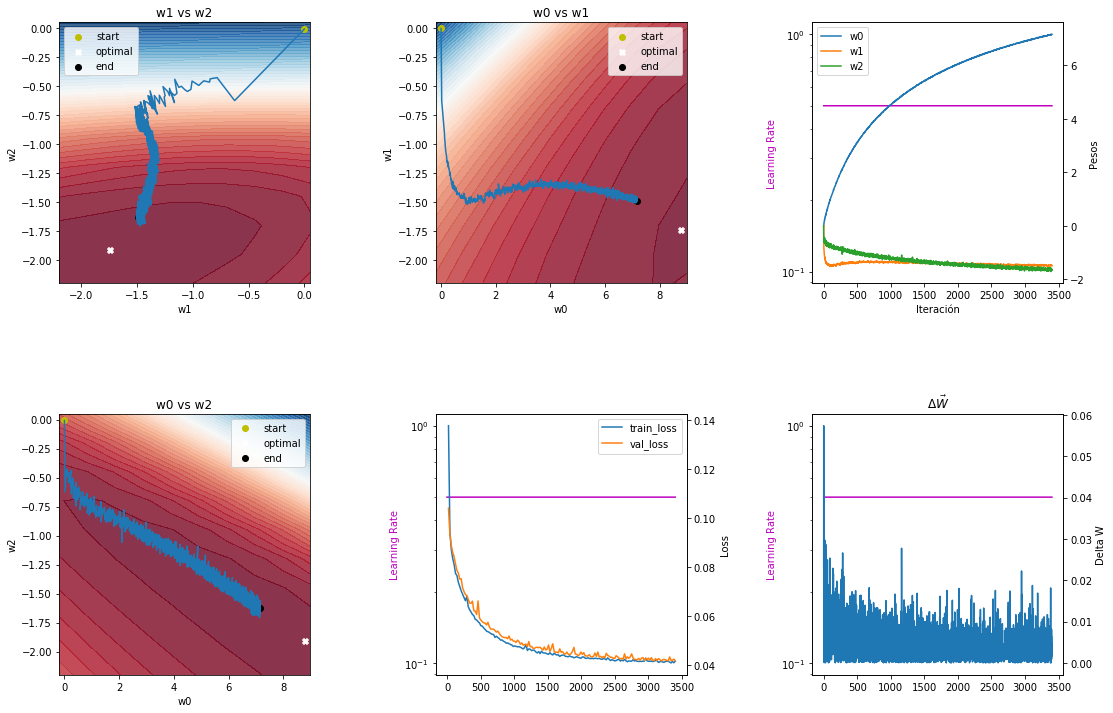

Epoch 00162: early stopping


In [27]:
history = model.fit(x_train, 
          y_train ,
          epochs=400,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping]
         )

El modelo no termina de converger ya que el learning rate es muy alto y no se estabiliza en un mínimo. Bajemos el learning rate en el código anterior a 0.1./

Restoring model weights from the end of the best epoch


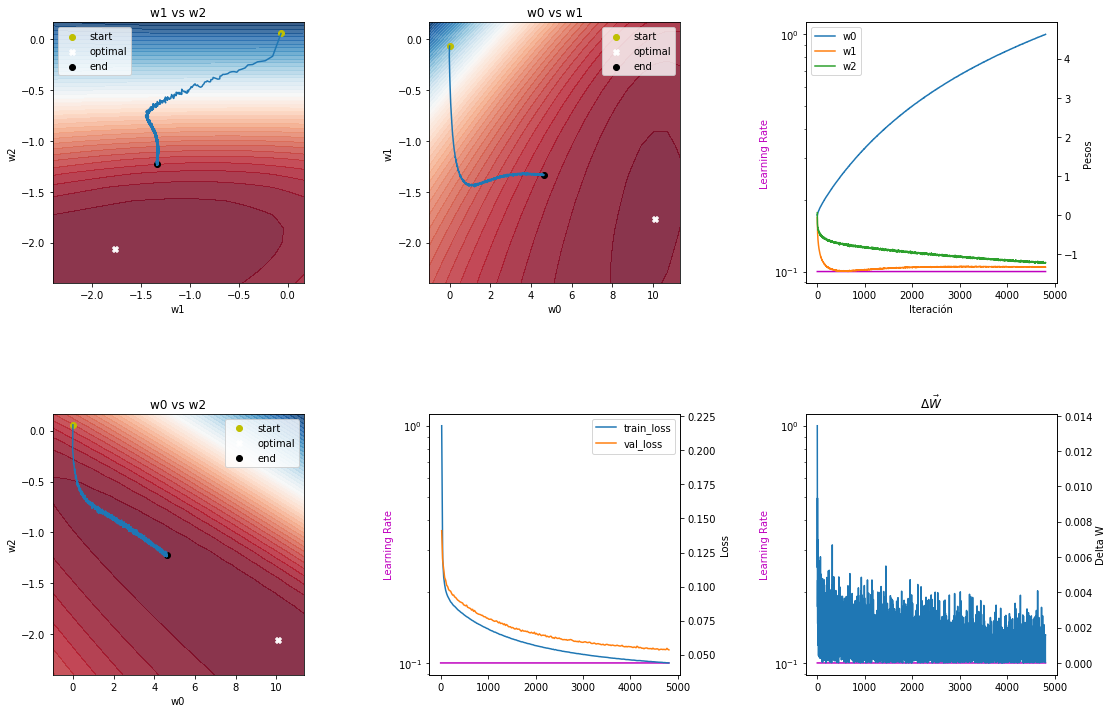

Epoch 00229: early stopping


In [64]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:],activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.1, decay=0,nesterov=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=10, verbose=1, restore_best_weights=True)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=400,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping]
         )

## LR Decay
La precisión bajó pero la convergencia es mas lenta. Podemos utilizar el parámetro "decay" del optimizador SGD. El mismo recalcula el learning rate según en qué iteración se encuentre:

$$ lr=lr_{base} * \frac{1}{1+iter} $$

Restoring model weights from the end of the best epoch


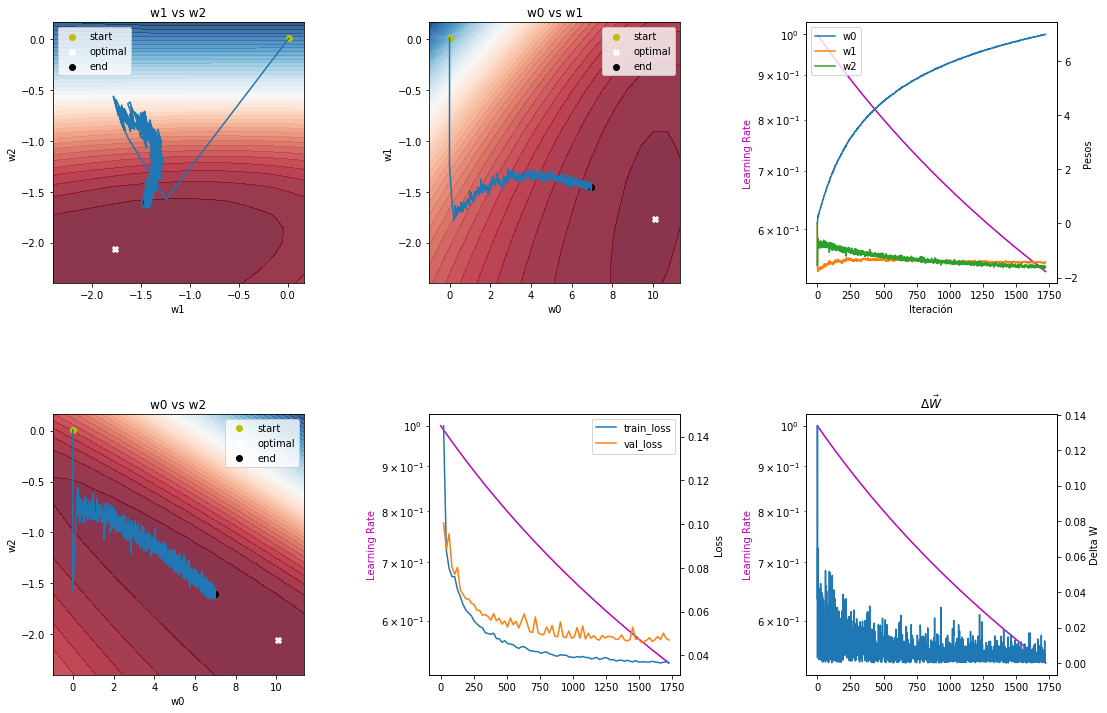

Epoch 00082: early stopping


In [65]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=1, decay=0.0005,nesterov=0)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=10, verbose=1, restore_best_weights=True)
logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=200,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping]
         )

## ReduceLRonPlateau
A veces establecer un schedule para el decay del learning rate es inviable prácticamente ya que la forma de la convergencia depende mucho de la inicialización. y la reducción del learning rate se hace cuando la convergencia no mejora luego de una cantidad de epochs definida.

In [3]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=1, decay=0,nesterov=0)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.6, 
                           patience=10, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)

logWeights=OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                 plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=400,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR]
         )

NameError: name 'Sequential' is not defined

## Momento

- SGD tiene problemas si hay una caída abrupta en una de las dimensiones: o tarda mucho en converger, o diverge.
- Se utilizan momentos para acelerar la actualización de los pesos en la dirección en la que la derivada parcial es mas suave, y frenarlo en la dirección en la que la derivada parcial es mas pronunciada.
- El equivalente físico es pensar que se le da inercia a la actualización de los pesos, como si la ubicación de los pesos se correspondieran con una bola cayendo por la superficie de la loss.
- Esto se logra sumando una fracción del update de pesos en el instante de tiempo anterior, además de sumar el pudate del instante actual:

$$ \Delta \vec W(k)= \gamma \Delta \vec W(k-1) - \eta \nabla(J(\mathbf{\omega})) $$
$$ \vec W(k+1) = \vec W(k) + \Delta \vec W(k) $$

Típicamente se utilizar un valor de momento de $\gamma = 0.9 $


Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.06000000089406967.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 0.03600000143051147.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.02160000130534172.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.012960000336170197.

Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0077759999781846995.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.004665600042790174.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.002799360081553459.

Epoch 00088: ReduceLROnPlateau reducing learning rate to 0.0016796160489320755.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0010077696293592452.

Epoch 00098: ReduceLROnPlateau reducing learning rate to 0.0006046617636457086.

Epoch 00103: ReduceLROnPlateau reducing learning rate to 0.00036279705818742514.
Restoring model weights from the end of the best epoch

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.00

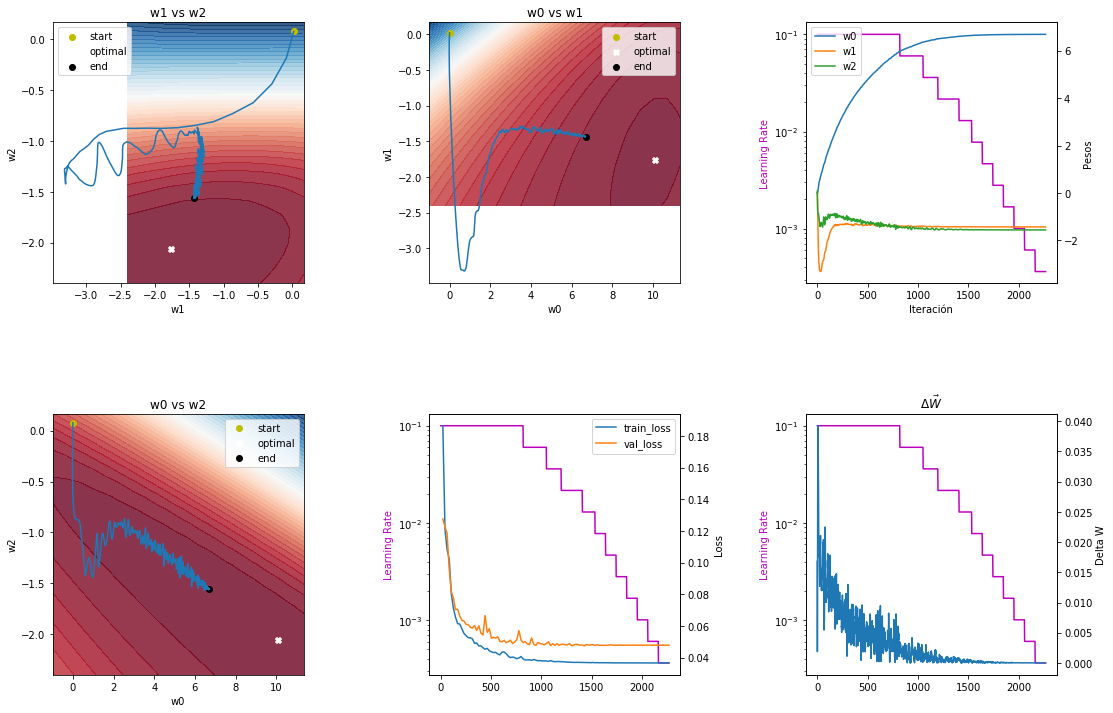

Epoch 00108: early stopping


In [67]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.1, decay=0,momentum=0.9,nesterov=0)
model.compile(loss = 'binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.6, 
                           patience=5, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)

logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs=400,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_test, y_test), 
          callbacks=[logWeights, earlyStopping, reduceLR]
         )

## Momentos de Nesterov

También llamado Nesterov Acelerated Gradient (NAG).  
El problema con los momentos es que la convergencia suele tener una naturaleza fuertmente oscilatoria. Ya que el gradiente es calculado en $\vec W(k)$ y se le suma la inercia en el mismo punto.
El momento de nesterov consiste en aplicar primero el término de la inercia, ver dónde queda los pesos resultantes, y aplicar el gradiente desde ese punto.

$$ \Delta \vec W(k)= \gamma \Delta \vec W(k-1) - \eta \nabla(J(\mathbf{W(k)}+\gamma \Delta \vec W(k-1))) $$
$$ \vec W(k+1) = \vec W(k) + \Delta \vec W(k) $$

Si debido al término de inercia los pesos quedan ya del otro lado del mínimo, el gradiente $\nabla(J(\mathbf{W(k)}+\gamma \Delta \vec W(k-1))$ tendrá sentido opuesto y la convergencia será mas estable.


Epoch 00504: ReduceLROnPlateau reducing learning rate to 0.48000000715255736.

Epoch 00563: ReduceLROnPlateau reducing learning rate to 0.28800001144409176.


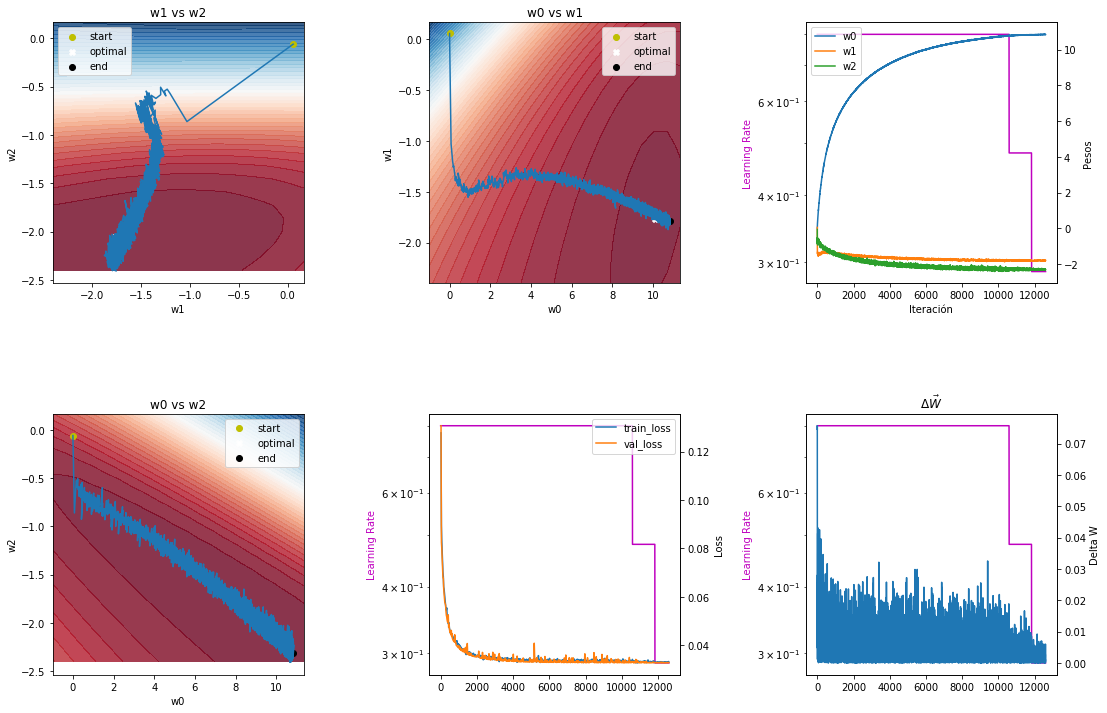

In [68]:
model = Sequential()
model.add(Dense(1, input_shape=x_train.shape[1:], activation='sigmoid', 
                kernel_initializer='normal', name='salida'))

optimizer = optimizers.SGD(lr=0.8, decay=0,momentum=0,nesterov=0.9)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

earlyStopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, 
                            patience=40, verbose=1, restore_best_weights=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.6, 
                           patience=20, 
                           verbose=1, 
                           min_delta=0, 
                           cooldown=0, min_lr=0)

logWeights = OPT_helper.log_weights(get_weights,
                                  set_weights,
                                  surface_filename="./surface.pck",
                                  w1_range=[-2.4,0.3],
                                  w2_range=[-2.4,0.3],
                                  w0_range=[-1,12],
                                  n_points=20,
                                  w1_opt=-1.8372542,
                                  w2_opt=-2.325091,
                                  w0_opt=6.3067813,
                                  plotloss_data=(x_train, y_train))

history = model.fit(x_train, 
          y_train ,
          epochs= 600,
          batch_size=128, 
          verbose=0, 
          validation_data=(x_train, y_train), 
          callbacks=[logWeights, earlyStopping, reduceLR]
         )